In [2]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import gc
import sklearn


# load data
# ../input/h-and-m-personalized-fashion-recommendations/
original_df_customers = pd.read_csv('./customers.csv')
original_df_items = pd.read_csv('./articles.csv')
original_df_customers_items = pd.read_csv('./transactions_train.csv')

submission_file = pd.read_csv('./sample_submission.csv')

# CLEANING DATA CUSTOMERS

In [3]:
original_df_customers = original_df_customers.drop(
    columns=['FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'postal_code'])


In [4]:
original_df_customers['age'].fillna(
    (original_df_customers['age'].mean()), inplace=True)
original_df_customers['age'] = original_df_customers['age'].astype(np.int8)


<AxesSubplot:ylabel='Frequency'>

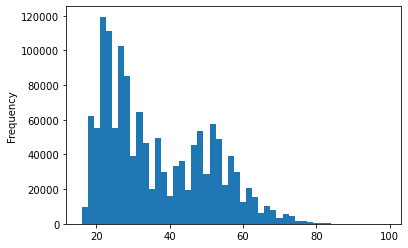

In [5]:
original_df_customers["age"].plot.hist(bins=50)


In [6]:
bins = [20, 21, 55, 110]
labels = ['Teen', 'Adult', 'Senior']
original_df_customers['AgeGroup'] = pd.cut(
    original_df_customers['age'], bins=bins, labels=labels, right=False)


In [7]:
original_df_customers


,customer_id,age,AgeGroup
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49,Adult
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25,Adult
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24,Adult
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54,Adult
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52,Adult
...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,24,Adult
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,21,Adult
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,21,Adult
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,18,NaN


In [8]:
original_df_customers = original_df_customers.drop(columns=['age'])


# CLEANING DATA ITEMS

In [9]:
original_df_items.columns


Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [10]:
for i in range(len(original_df_items.columns)):
    print(original_df_items.columns[i] + " " + str(
        len(original_df_items[original_df_items.columns[i]].unique())))


article_id 105542
product_code 47224
prod_name 45875
product_type_no 132
product_type_name 131
product_group_name 19
graphical_appearance_no 30
graphical_appearance_name 30
colour_group_code 50
colour_group_name 50
perceived_colour_value_id 8
perceived_colour_value_name 8
perceived_colour_master_id 20
perceived_colour_master_name 20
department_no 299
department_name 250
index_code 10
index_name 10
index_group_no 5
index_group_name 5
section_no 57
section_name 56
garment_group_no 21
garment_group_name 21
detail_desc 43405


In [11]:
original_df_items['index_name'].unique()


array(['Ladieswear', 'Lingeries/Tights', 'Baby Sizes 50-98', 'Menswear',
       'Ladies Accessories', 'Sport', 'Children Sizes 92-140', 'Divided',
       'Children Sizes 134-170', 'Children Accessories, Swimwear'],
      dtype=object)

In [12]:
original_df_items.head(10)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
5,110065011,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,12,Light Beige,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
6,111565001,111565,20 den 1p Stockings,304,Underwear Tights,Socks & Tights,1010016,Solid,9,Black,...,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,"Semi shiny nylon stockings with a wide, reinfo..."
7,111565003,111565,20 den 1p Stockings,302,Socks,Socks & Tights,1010016,Solid,13,Beige,...,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,"Semi shiny nylon stockings with a wide, reinfo..."
8,111586001,111586,Shape Up 30 den 1p Tights,273,Leggings/Tights,Garment Lower body,1010016,Solid,9,Black,...,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Tights with built-in support to lift the botto...
9,111593001,111593,Support 40 den 1p Tights,304,Underwear Tights,Socks & Tights,1010016,Solid,9,Black,...,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,"Semi shiny tights that shape the tummy, thighs..."


In [13]:
original_df_items = original_df_items[["article_id", "product_group_name",
                                       "perceived_colour_value_name", "perceived_colour_master_name", "index_name", "garment_group_name"]]


# CLEANING TRANSACTIONS

In [14]:
original_df_customers_items = original_df_customers_items.drop(
    columns=['price', 'sales_channel_id'])


In [15]:
# original_df_customers_items['day'] = original_df_customers_items['t_dat'].dt.day
original_df_customers_items['t_dat'] = pd.to_datetime(
    original_df_customers_items['t_dat'], format='%Y-%m-%d')
original_df_customers_items['day'] = original_df_customers_items['t_dat'].dt.day
original_df_customers_items['month'] = original_df_customers_items['t_dat'].dt.month
original_df_customers_items['year'] = original_df_customers_items['t_dat'].dt.year


In [16]:
original_df_customers_items['season'] = pd.Categorical.from_codes(
    original_df_customers_items['t_dat'].dt.month % 12 // 3,
    categories=['winter', 'spring', 'summer', 'fall'],
    ordered=True
)

In [17]:
original_df_customers_items


,t_dat,customer_id,article_id,day,month,year,season
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,20,9,2018,fall
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,20,9,2018,fall
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,20,9,2018,fall
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,20,9,2018,fall
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,20,9,2018,fall
...,...,...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,22,9,2020,fall
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,22,9,2020,fall
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,22,9,2020,fall
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,22,9,2020,fall


In [18]:
original_df_customers_items = original_df_customers_items.drop(columns=['t_dat', 'month'])


In [19]:
value_counts = original_df_customers_items.article_id.value_counts()


In [20]:
#counts_items = original_df_items.merge(value_counts, left_on='article_id', right_on='article_id')
counts_items = pd.DataFrame(original_df_customers_items.article_id.value_counts().reset_index())
counts_items.columns = ['article_id', 'count']

# merge 'df' & 'brands_count'
original_df_customers_items = pd.merge(
    original_df_customers_items, counts_items, on='article_id')


# MERGE DATASETS

In [21]:
df_merged_1 = original_df_customers_items.merge(original_df_customers, left_on='customer_id', right_on='customer_id')
del original_df_customers_items
del original_df_customers
gc.collect()


0

In [22]:
df_merged_final = df_merged_1.merge(original_df_items, left_on='article_id', right_on='article_id')
del original_df_items
gc.collect()


0

In [23]:
df_merged_final.columns


Index(['customer_id', 'article_id', 'day', 'year', 'season', 'count',
       'AgeGroup', 'product_group_name', 'perceived_colour_value_name',
       'perceived_colour_master_name', 'index_name', 'garment_group_name'],
      dtype='object')

In [24]:
df_merged_final = df_merged_final[['customer_id', 'AgeGroup', 'article_id', 'product_group_name', 'perceived_colour_value_name',
                                   'perceived_colour_master_name', 'index_name', 'garment_group_name', 'count', 'day', 'year', 'season']]


In [25]:
df_merged_final


,customer_id,AgeGroup,article_id,product_group_name,perceived_colour_value_name,perceived_colour_master_name,index_name,garment_group_name,count,day,year,season
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,Adult,663713001,Underwear,Dark,Black,Lingeries/Tights,"Under-, Nightwear",633,20,2018,fall
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,Adult,663713001,Underwear,Dark,Black,Lingeries/Tights,"Under-, Nightwear",633,24,2018,fall
2,3681748607f3287d2c3a65e00bb5fb153de30e9becf158...,Adult,663713001,Underwear,Dark,Black,Lingeries/Tights,"Under-, Nightwear",633,20,2018,fall
3,4ef5967ff17bf474bffebe5b16bd54878e1d4105f7b4ed...,Adult,663713001,Underwear,Dark,Black,Lingeries/Tights,"Under-, Nightwear",633,20,2018,fall
4,6b7b10d2d47516c82a6f97332478dab748070f09693f09...,Adult,663713001,Underwear,Dark,Black,Lingeries/Tights,"Under-, Nightwear",633,20,2018,fall
...,...,...,...,...,...,...,...,...,...,...,...,...
31788319,4ca50ab0f37796255987977b491b789de721574bbff2fe...,Adult,867104008,Garment Upper body,Dark,Black,Children Sizes 134-170,Jersey Fancy,1,7,2020,fall
31788320,7717ad1e0fb27a0e626c8336681b3e2c576f52b9056a4d...,NaN,885434003,Garment Full body,Dark,Grey,Baby Sizes 50-98,Jersey Fancy,1,7,2020,fall
31788321,e6bbee0c75615780a6da27ce37b6b7a8a77e0756dc9786...,Adult,940483001,Garment Upper body,Dark,Brown,Ladieswear,Outdoor,1,21,2020,fall
31788322,343e5db9a9dd28e21dd8f8e9a1c41989f22ab117290479...,Adult,921715001,Accessories,Medium Dusty,Brown,Menswear,Accessories,1,17,2020,fall


In [26]:
article_ids = np.unique(df_merged_final.article_id.values)
customer_ids = np.unique(df_merged_final.customer_id.values)

num_articles = len(article_ids)
num_customers = len(customer_ids)

# Create dictionaries with mapping keys
articles_id_to_idx = dict(zip(article_ids, range(num_articles)))
customers_id_to_idx = dict(zip(customer_ids, range(num_customers)))

articles_idx_to_id = dict(zip(range(num_articles), article_ids))
customers_idx_to_id = dict(zip(range(num_customers), customer_ids))


In [27]:
articles_id_to_idx

{108775015: 0,
 108775044: 1,
 108775051: 2,
 110065001: 3,
 110065002: 4,
 110065011: 5,
 111565001: 6,
 111565003: 7,
 111586001: 8,
 111593001: 9,
 111609001: 10,
 112679048: 11,
 112679052: 12,
 114428026: 13,
 114428030: 14,
 116379047: 15,
 118458003: 16,
 118458004: 17,
 118458028: 18,
 118458029: 19,
 118458034: 20,
 118458038: 21,
 118458039: 22,
 120129001: 23,
 120129014: 24,
 120129018: 25,
 120129025: 26,
 123173001: 27,
 126589006: 28,
 126589007: 29,
 126589010: 30,
 126589011: 31,
 126589012: 32,
 129085001: 33,
 129085026: 34,
 129085027: 35,
 130035001: 36,
 141661022: 37,
 141661025: 38,
 144993001: 39,
 145872001: 40,
 145872037: 41,
 145872043: 42,
 145872051: 43,
 145872052: 44,
 145872053: 45,
 146706001: 46,
 146706004: 47,
 146706005: 48,
 146721001: 49,
 146721002: 50,
 146730001: 51,
 147339034: 52,
 148033001: 53,
 148033006: 54,
 150959011: 55,
 150959013: 56,
 153115019: 57,
 153115020: 58,
 153115021: 59,
 153115039: 60,
 153115040: 61,
 153115043: 62,
 1

In [28]:
def top_bought_articles(df, n):
    return df.value_counts().head(n)


In [29]:
top_12 = top_bought_articles(df_merged_final['article_id'], 12)

In [30]:
top_12 = top_12.to_numpy()

In [31]:
# Assign the customer and article indices to the transactions and drop the ids
df_merged_final['customer_index'] = df_merged_final.customer_id.map(
    customers_id_to_idx)
df_merged_final['article_index'] = df_merged_final.article_id.map(
    articles_id_to_idx)

df_merged_final.drop(['customer_id', 'article_id'], inplace=True, axis=1)


In [32]:
df_merged_final = df_merged_final[[
    'customer_index', 'AgeGroup', 'article_index', 'product_group_name']]


In [33]:
df_merged_final


,customer_index,AgeGroup,article_index,product_group_name
0,2,Adult,40140,Underwear
1,2,Adult,40140,Underwear
2,289798,Adult,40140,Underwear
3,419339,Adult,40140,Underwear
4,571912,Adult,40140,Underwear
...,...,...,...,...
31788319,407053,Adult,95313,Garment Upper body
31788320,633749,NaN,99143,Garment Full body
31788321,1227640,Adult,104446,Garment Upper body
31788322,277973,Adult,103565,Accessories


In [34]:
df_merged_final['sale'] = 1
data_aux = df_merged_final.copy()
data_aux['sale'] = 0  # -1

data_aux['customer_index'] = data_aux['customer_index'].sample(frac=1, ignore_index=True)
data_aux['article_index'] = data_aux['article_index'].sample(frac=1, ignore_index=True)


/var/folders/7h/_g5c7h9d0y194g8p8d8jkm140000gn/T/ipykernel_12093/2244873165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_final['sale'] = 1


In [35]:
df_merged_final = df_merged_final.merge(data_aux, how='outer')

# One Hot Encoding

In [36]:
y = df_merged_final['sale']
X = df_merged_final.drop(['sale'], axis=1)

In [37]:
columns = X.columns

In [38]:
from sklearn.preprocessing import LabelEncoder


def one_hot_encoding(data, categorical_cols, sparse=True, df=False):
    # instantiate labelencoder object
    le = LabelEncoder()

    # apply le on categorical feature columns
    data[categorical_cols] = data[categorical_cols].apply(
        lambda col: le.fit_transform(col))

    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(sparse=True)

    # One-hot-encode the categorical columns.
    # Unfortunately outputs an array instead of dataframe.
    array_hot_encoded = ohe.fit_transform(data[categorical_cols])
    print(type(array_hot_encoded))

    if df == True:
        # Convert it to df
        data_hot_encoded = pd.DataFrame(array_hot_encoded, index=data.index)

        # Extract only the columns that didnt need to be encoded
        data_other_cols = data.drop(columns=categorical_cols)

        # Concatenate the two dataframes :
        data_out = pd.concat([data_hot_encoded, data_other_cols], axis=1)
        return le, ohe, data_out
    else:
        return le, ohe, array_hot_encoded


In [39]:
le, ohe_func, array_hot_encoded = one_hot_encoding(
    X, columns, sparse=True, df=False)


<class 'scipy.sparse._csr.csr_matrix'>


In [40]:
import scipy
scipy.sparse.save_npz('./sparse_matrix.npz', array_hot_encoded)
# sparse_matrix = scipy.sparse.load_npz('./sparse_matrix.npz')


## Lesson 4: Collaborative-based recommender systems: Factorization MODELS

Matrix factorization is a simple embedding model, which decomposes the user-item intraction matrix, $R \in R^{m\times n}$ matrix, where $m$ is the number of users and $n$ the number of items, into the product of two lower dimensionality rectangular matrice. The the goal of the factorization models is to learn:
* A user embedding (or user latent factor) $P \in R^{m\times k}$, where row $i$ is the embedding of user $i$.
* A item embedding (or item latent factor) $Q \in R^{n\times k}$, where row $j$ is the embedding of user $j$.

![alt factorization models](https://miro.medium.com/max/988/1*nIVWl2ROaxOY23hHajkTTg.png)

These methods became really popular due to the shown efficiency in the Netflix Prize Challenge. 

There are several variants of these methods:
* SVD 
* Vanilla Factorization Matrix (also knwon as Funk SVD)
* Vanilla Factorization Matrix with biases 
* SVD++
* ...

In these notewook we will the application of these method to the transactionLens dataset.

In [ ]:
from scipy.sparse import csr_matrix, dok_matrix


def to_dense(array):
    """
    Accepta una csr_matrix, dok_matrix o matrix i la converteix en una 
    np.array normal, densa.

    :param array: Array a convertir
    :return: np.array densa, sense cap dimensió de tamany 1
    """
    try:
        array = array.todense()
    except:
        pass

    return np.array(array).squeeze()


In [ ]:
def evaluate(predict_f, data_train, data_test):
    """ RMSE-based predictive performance evaluation with pandas. """
    ids_to_estimate = zip(data_test.customer_id, data_test.article_id)
    list_users = set(data_train.customer_id)
    estimated = np.array(
        [predict_f(u, i) if u in list_users else 0.5 for (u, i) in ids_to_estimate])
    real = data_test['sale'].values
    return compute_rmse(estimated, real)


def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))


# Divide the data in two sets: training and test
def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.2)),
                                   replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    return df


### The Vanilla Matrix Factorization Model 
* Also know as **Funk SVD**
* * Despite its name, in Funk SVD, no singular value decomposition is applied.
* * https://sifter.org/simon/journal/20061211.html

A straightforward matrix factorization model maps both users and items to a joint latent factor space of dimensionality D. User-item interaction are modeled as inner products in that space
$$R = UV$$

Each item j is associated with a vector $v_j$ from $V$, and each user $i$ is associated with a vecor $u_i$ from $U$.
The resulting dot product $u_i\cdot v_j$ captures the interaction between the user $i$ and item $j$:
$$ \hat{r} = u_i\cdot v_j$$

The goal of the matrix factorization consist on finding the mapping of each item and user to factors $u_i$ and $v_j$. To do so, the minimization the of squarred error function is performed:
$$ \sum(R_{ui} - u_i\cdot v_j)^2$$

This factorization can be learnt using **only those known ratings**. We do not need to infer missing values.

![alt Amazon](https://miro.medium.com/max/4800/1*b4M7o7W8bfRRxdMxtFoVBQ.png)

In [ ]:
from scipy import sparse
import matplotlib.pyplot as plt
from numba import njit, jit


class RecSys_mf():
    def __init__(self, article_ids, customer_ids, num_components=10):
        """ Constructor """
        self.num_components = num_components

        self.article_ids = article_ids
        self.customer_ids = customer_ids

        self.num_articles = len(self.article_ids)
        self.num_customers = len(self.customer_ids)

        # Create dictionaries with mapping keys
        self.article_id2index = dict(zip(article_ids, range(num_articles)))
        self.customer_id2index = dict(zip(customer_ids, range(num_customers)))
        self.article_index2id = dict(zip(range(num_articles), article_ids))
        self.customer_index2id = dict(zip(range(num_customers), customer_ids))


class RecSys_vanilla_mf(RecSys_mf):

    def __init__(self, matrix, sales, article_ids, customer_ids, top_12, reg_w=0.01, reg_v=0.01, num_components=10, seed=42):
        """ Constructor """
        super().__init__(article_ids, customer_ids, num_components)
        self.matrix = matrix
        self.y = sales.to_numpy(dtype=np.int8)
        self.top_12 = top_12
        self.seed = seed   # Random seed

        self.reg_w = reg_w
        self.reg_v = reg_v

    def fit(self, n_epochs=10, learning_rate=0.001, lmbda=0.1, verbose=True):
        """ We decompose the R matrix into to submatrices using the training data """
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.lmbda = lmbda

        self.n_samples, self.n_features = self.matrix.shape
        # Initialize weights
        self.w0 = np.random.normal(scale=1, size=1)
        self.w = np.random.normal(
            scale=1/self.n_features, size=self.n_features)
        self.v = np.random.normal(
            scale=1./self.n_features, size=(self.num_components, self.n_features))

        self.train_rmse = []
        
        print(type(self.y))

        for epoch in tqdm(range(n_epochs)):
            print('Epoch: {}'.format(epoch))

            self.training_indices = np.arange(self.n_samples)

            # self.__shuffle_sales__()
            # shuffle training samples
            np.random.shuffle(self.training_indices)
            __sdg__(self.matrix.data, self.matrix.indptr, self.matrix.indices, self.y, self.n_samples, self.n_features,
                    self.w0, self.w, self.v, self.num_components, self.learning_rate, self.reg_w, self.reg_v)

            # self.train_rmse.append(evaluate(self.predict, self.matrix, self.matrix))

            # print('\tTrain rmse: %s' % self.train_rmse[-1])

        if(self.verbose):
            self.__plot_learning_curves__()

    def __shuffle_sales__(self):
        """ Shuffle negative samples """
        self.y = np.random.shuffle(self.y)

    def __plot_learning_curves__(self):
        plt.plot(self.train_rmse, '--o', label="train_error")
        plt.plot(self.test_rmse, '--o', label="test_error")
        plt.legend()
        plt.show()

    def predict(self, customers):
        """Similar to _predict_instance but vectorized for all samples"""
        
        results = pd.DataFrame(columns=['customer_id', 'predict'])

        for idx, customer in enumerate(tqdm(customers.customer_id.unique())):
            if customer not in self.customer_id2index.keys():
                # If the the customer is not in the trained ones return the default recommendation
                article_ids = self.top_12
            else:
                customer_idx = self.customer_id2index[customer]
                
                summed = np.zeros(self.num_components)
                summed_squared = np.zeros(self.num_components)

                # linear output w * x
                pred = self.w0
                for index in range(self.matrix.indptr[customer_idx], self.matrix.indptr[customer_idx + 1]):
                    feature = self.matrix.indices[index]
                    pred += self.w[feature] * self.matrix.data[index]

                # factor output
                for factor in range(self.num_components):
                    for index in range(self.matrix.indptr[customer_idx], self.matrix.indptr[customer_idx + 1]):
                        feature = self.indices[index]
                        term = self.v[factor, feature] * self.matrix.data[index]
                        summed[factor] += term
                        summed_squared[factor] += term * term

                    pred += 0.5 * (summed[factor] * summed[factor] - summed_squared[factor])
                
                recommended = pred.argsort()[-12:]
                
                article_ids = ' '.join([self.article_index2id[item_idx] for item_idx in recommended])
            
            results.loc[idx] = (customer, ''.join(article_ids))
            
        return results


def __sdg__(data, indptr, indices, y, n_samples, n_features, w0, w, v, n_factors, learning_rate, reg_w, reg_v):
    """
    Compute the loss of the current iteration and update
    gradients accordingly.
    """
    loss = 0.0
    for i in range(n_samples):
        pred, summed = _predict_instance(
            data, indptr, indices, w0, w, v, n_factors, i)

        # calculate loss and its gradient
        loss += _log_loss(pred, y[i])
        loss_gradient = -y[i] / (np.exp(y[i] * pred) + 1.0)

        # update bias/intercept term
        w0 -= learning_rate * loss_gradient

        # update weight
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            w[feature] -= learning_rate * \
                (loss_gradient * data[index] + 2 * reg_w * w[feature])

        # update factor
        for factor in range(n_factors):
            for index in range(indptr[i], indptr[i + 1]):
                feature = indices[index]
                term = summed[factor] - v[factor, feature] * data[index]
                v_gradient = loss_gradient * data[index] * term
                v[factor, feature] -= learning_rate * \
                    (v_gradient + 2 * reg_v * v[factor, feature])

    loss /= n_samples
    return loss


def _predict_instance(data, indptr, indices, w0, w, v, n_factors, i):
    """predicting a single instance"""
    summed = np.zeros(n_factors)
    summed_squared = np.zeros(n_factors)

    # linear output w * x
    pred = w0
    for index in range(indptr[i], indptr[i + 1]):
        feature = indices[index]
        pred += w[feature] * data[index]

    # factor output
    for factor in range(n_factors):
        for index in range(indptr[i], indptr[i + 1]):
            feature = indices[index]
            term = v[factor, feature] * data[index]
            summed[factor] += term
            summed_squared[factor] += term * term

        pred += 0.5 * (summed[factor] * summed[factor] -
                       summed_squared[factor])

    # summed is the independent term that can be re-used
    # during the gradient update stage
    return pred, summed


def _log_loss(pred, y):
    """
    negative log likelihood of the
    current prediction and label, y.
    """
    return np.log(np.exp(-pred * y) + 1.0)


In [ ]:
reco = RecSys_vanilla_mf(array_hot_encoded, y, article_ids, customer_ids,
                         top_12, reg_w=0.01, reg_v=0.01, num_components=10, seed=42)
reco.fit(n_epochs=20, learning_rate=0.01, lmbda=0.5, verbose=True)


In [ ]:
result = reco._predict(submission_file)

In [ ]:
df_aux = result.explode(column='prediction')
df_aux.prediction = '0' + df_aux.prediction
df_aux.head()

In [ ]:
def group(list_of_strings):
    return " ".join(list_of_strings)
    
sub = df_aux.groupby('customer_id')['prediction'].agg(lambda x: group(x)).reset_index()

sub.to_csv('submission.csv', index=False)